In [10]:
# Importando as bibliotecas
import pymusas
import pandas as pd
import spacy
import os
import matplotlib.pyplot as plt
import requests

# Repositiorio que deve ser clonado: https://github.com/UCREL/Multilingual-USAS.git

# instale pyMUSAS: pip install pymusas

# Depois instale dependencias do spacy:
# pip install https://github.com/UCREL/pymusas-models/releases/download/en_dual_upos2usas_contextual-0.3.3/en_dual_upos2usas_contextual-0.3.3-py3-none-any.whl
# pip install https://github.com/UCREL/pymusas-models/releases/download/en_dual_none_contextual-0.3.3/en_dual_none_contextual-0.3.3-py3-none-any.whl
# python -m spacy download pt_core_news_sm
# Documentação que pode ajudar: https://ucrel.github.io/pymusas/

# pip install https://github.com/UCREL/pymusas-models/releases/download/es_dual_upos2usas_contextual-0.3.3/es_dual_upos2usas_contextual-0.3.3-py3-none-any.whl
# python3 -m spacy download es_core_news_sm


In [57]:
plots = pd.read_csv("./data/oscar_full_plot.csv", sep=';')
plots.set_index("TITULO", inplace = True)

In [45]:
nlp_pt = spacy.load('pt_core_news_sm', exclude=['parser', 'ner'])
portuguese_tagger_pipeline = spacy.load('pt_dual_upos2usas_contextual')
nlp_pt.add_pipe('pymusas_rule_based_tagger', source=portuguese_tagger_pipeline)

nlp_en = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
english_tagger_pipeline = spacy.load('en_dual_none_contextual')
nlp_en.add_pipe('pymusas_rule_based_tagger', source=english_tagger_pipeline)

nlp_es = spacy.load('es_core_news_sm', exclude=['parser', 'ner'])
spanish_tagger_pipeline = spacy.load('es_dual_upos2usas_contextual')
nlp_es.add_pipe('pymusas_rule_based_tagger', source=spanish_tagger_pipeline)

/opt/homebrew/lib/python3.11/site-packages/pymusas/spacy_api/utils.py:38: UserWarning: Overwritten the spaCy Token extension `pymusas_tags` which currently has the following (default, method, getter, setter):`(None, None, None, None)`. And replacing it with the following:`(None, None, None, None)`. This would only become a problem if the the two Tuples of four are different, if they are the same there is no problem.
  warnings.warn(message)
/opt/homebrew/lib/python3.11/site-packages/pymusas/spacy_api/utils.py:38: UserWarning: Overwritten the spaCy Token extension `pymusas_mwe_indexes` which currently has the following (default, method, getter, setter):`(None, None, None, None)`. And replacing it with the following:`(None, None, None, None)`. This would only become a problem if the the two Tuples of four are different, if they are the same there is no problem.
  warnings.warn(message)


In [42]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_pt(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [43]:
path = './data/plots_pt'
text = ""
list_files = os.listdir(path)

In [44]:
#list_files = ["E.T. O Extraterrestre.txt", "Star Wars: Episódio IV – Uma Nova Esperança.txt", "Black Panther (filme).txt"]
results = []
for file in list_files:
    name = file.split(".txt")
    # if name[0] in plots["TITLE_PT"].values:
    if name[0] in plots["TITULO"].values:
        article = open(path + "/" + file, 'r')
        content = article.read()
        result = process_text(content)
        results.append(result)
len(results)

6

In [72]:
print(len(results[0]))

183


In [70]:
print(len(results))

513


In [6]:
dict_categ = {}
for result in results[0]:
    if result['POS'] not in dict_categ.keys():
        dict_categ[result['POS']] = 1
    else:
        dict_categ[result['POS']] += 1

print(dict_categ)

{'ADP': 22, 'NUM': 5, 'NOUN': 30, 'PUNCT': 27, 'DET': 15, 'PROPN': 21, 'VERB': 15, 'CCONJ': 12, 'PRON': 14, 'AUX': 7, 'ADV': 9, 'ADJ': 3, 'SCONJ': 2, 'SPACE': 1}


In [ ]:
df = pd.DataFrame({
    "Categoria": dict_categ.keys(),
    "Frequencia": dict_categ.values()
}) 
df = df.sort_values('Frequencia', ascending=False)
df["Frequencia"] = df["Frequencia"] / df["Frequencia"].sum()
df

In [ ]:
df.plot(x="Categoria", y=["Frequencia"], kind='bar', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Português - Pymusas")
plt.show()

In [35]:
# url = "https://ucrel.lancs.ac.uk/usas/semtags_subcategories.txt"
# response = requests.get(url)

# # Check if the request was successful (status code 200)
# if response.status_code == 200:
#     # Save the content of the response to a local CSV file
#     with open("pymusas_dict.csv", "wb") as f:
#         f.write(response.content)
#     print("CSV file downloaded successfully")
# else:
#     print("Failed to download CSV file. Status code:", response.status_code)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv("pymusas_dict.csv", sep=";")
df["Count"] = [0 for i in range(len(df))]
df.set_index('Tag', inplace=True)
df

,Categoria,Count
Tag,,
A1,General And Abstract Terms,0
A1.1.1,General actions / making,0
A1.1.1-,Inaction,0
A1.1.2,Damaging and destroying,0
A1.1.2-,Fixing and mending,0
...,...,...
Z7,If,0
Z7-,Unconditional,0
Z8,Pronouns,0


In [36]:
for result in results:
    for sub_result in result:
        for tag in sub_result['USAS Tags']:
            if tag in df.index:
                df.at[tag, 'Count'] += 1

df["Count"] = df["Count"] / df["Count"].sum()
df = df.reset_index()
for index, row in df.iterrows():
    if row["Count"] == 0:
        df = df.drop(index)
df = df.sort_values(by="Count", ascending=False)
df

,Tag,Categoria,Count
446,Z5,Grammatical bin,0.183987
452,Z99,Unmatched,0.161077
208,M6,Location and direction,0.044639
450,Z8,Pronouns,0.039443
350,S8+,Helping,0.025035
...,...,...,...
391,X2.5,Understand,0.000236
221,N3.4,Measurement: Volume,0.000236
393,X2.5-,Not understanding,0.000236
220,N3.3-,Distance: Near,0.000236


In [37]:
df_aux = df.drop([446, 452, 450])
df_aux

,Tag,Categoria,Count
208,M6,Location and direction,0.044639
350,S8+,Helping,0.025035
46,A5.1+,Evaluation: Good,0.023382
1,A1.1.1,General actions / making,0.021020
211,N1,Numbers,0.016060
...,...,...,...
391,X2.5,Understand,0.000236
221,N3.4,Measurement: Volume,0.000236
393,X2.5-,Not understanding,0.000236
220,N3.3-,Distance: Near,0.000236


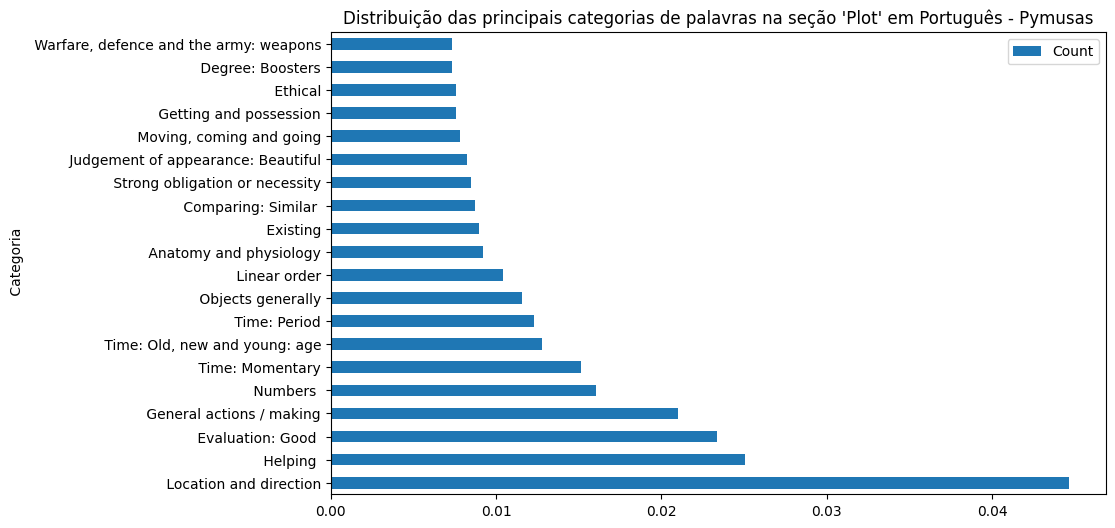

In [38]:
films = ["La La Land (film).txt", "The Wizard of Oz (1939).txt", "Titanic (filme de 1997).txt", "Titanic (filme de 1997).txt"]
df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras na seção 'Plot' em Português - Pymusas")
plt.yticks(fontsize=10)
plt.show()

In [67]:
path = './data/plots_en'
text = ""
list_files = os.listdir(path)
print(list_files)

['CODA (2021 film).txt', 'Peyton Place (film).txt', 'The Good Earth (film).txt', 'Crossfire (film).txt', 'Black Panther (film).txt', 'The Favourite.txt', 'Les Misérables (1935 film).txt', 'Barry Lyndon.txt', 'Heaven Can Wait (1978 film).txt', 'Extremely Loud & Incredibly Close (film).txt', 'Boys Town (film).txt', 'Dunkirk (2017 film).txt', 'Three Billboards Outside Ebbing, Missouri.txt', 'The Bridge on the River Kwai.txt', 'America America.txt', 'Philomena (film).txt', 'Mutiny on the Bounty (1962 film).txt', 'Hacksaw Ridge.txt', 'Three Smart Girls.txt', 'Crash (2004 film).txt', 'Nicholas and Alexandra.txt', 'Jerry Maguire.txt', 'Bugsy.txt', 'A Tale of Two Cities (1935 film).txt', 'One Hundred Men and a Girl.txt', 'Five Star Final.txt', 'The Accidental Tourist (film).txt', "William Shakespeare's Julius Caesar.txt", 'The Towering Inferno.txt', 'In Old Chicago.txt', 'Mr. Smith Goes to Washington.txt', 'Midnight Cowboy.txt', 'Hell or High Water (film).txt', 'Marty (film).txt', 'Out of Afri

In [68]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_en(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [71]:
#list_files = ["E.T. the Extra-Terrestrial.txt", "Star Wars (film).txt", "Dune (2021 film).txt", "Black Panther (film).txt"]
results = []
for file in list_files:
    name = file.split(".txt")
    classif = movies_classification["MOVIE THAT ADDRESSES SOCIAL TOPICS"]
    print(name[0].upper())
    if name[0].upper() in plots["TITLE_EN"].str.upper().values and name[0] in classif:
        print(name[0])
        article = open(path + "/" + file, 'r')
        content = article.read()
        result = process_text(content)
        results.append(result)
len(results)

CODA (2021 FILM)
PEYTON PLACE (FILM)
THE GOOD EARTH (FILM)
CROSSFIRE (FILM)
BLACK PANTHER (FILM)
THE FAVOURITE
LES MISÉRABLES (1935 FILM)
BARRY LYNDON
HEAVEN CAN WAIT (1978 FILM)
EXTREMELY LOUD & INCREDIBLY CLOSE (FILM)
BOYS TOWN (FILM)
DUNKIRK (2017 FILM)
THREE BILLBOARDS OUTSIDE EBBING, MISSOURI
THE BRIDGE ON THE RIVER KWAI
AMERICA AMERICA
PHILOMENA (FILM)
MUTINY ON THE BOUNTY (1962 FILM)
HACKSAW RIDGE
THREE SMART GIRLS
CRASH (2004 FILM)
NICHOLAS AND ALEXANDRA
JERRY MAGUIRE
BUGSY
A TALE OF TWO CITIES (1935 FILM)
ONE HUNDRED MEN AND A GIRL
FIVE STAR FINAL
THE ACCIDENTAL TOURIST (FILM)
WILLIAM SHAKESPEARE'S JULIUS CAESAR
THE TOWERING INFERNO
IN OLD CHICAGO
MR. SMITH GOES TO WASHINGTON
MIDNIGHT COWBOY
HELL OR HIGH WATER (FILM)
MARTY (FILM)
OUT OF AFRICA (FILM)
THE GODFATHER PART II
WUTHERING HEIGHTS (1939 FILM)
THE BROADWAY MELODY
SPOTLIGHT (FILM)
IL POSTINO: THE POSTMAN
FIELD OF DREAMS
WITNESS (1985 FILM)
SEABISCUIT (FILM)
KRAMER VS. KRAMER
MICHAEL CLAYTON
BABE (FILM)
THE WIZARD OF OZ


0

In [102]:
dict_categ = {}
for result in results[0]:
    if result['POS'] not in dict_categ.keys():
        dict_categ[result['POS']] = 1
    else:
        dict_categ[result['POS']] += 1

print(dict_categ)

{'PROPN': 69, 'PUNCT': 88, 'NUM': 4, 'NOUN': 115, 'SPACE': 8, 'ADP': 77, 'DET': 38, 'ADJ': 32, 'AUX': 34, 'VERB': 96, 'PRON': 76, 'CCONJ': 28, 'PART': 29, 'ADV': 22, 'SCONJ': 19}


In [ ]:
df = pd.DataFrame({
    "Categoria": dict_categ.keys(),
    "Frequencia": dict_categ.values()
}) 
df = df.sort_values('Frequencia', ascending=False)
df["Frequencia"] = df["Frequencia"] / df["Frequencia"].sum()
df

In [ ]:
df.plot(x="Categoria", y=["Frequencia"], kind='bar', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Inglês - Pymusas")
plt.show()

In [57]:
df = pd.DataFrame({
    "Categoria": dict_categ.keys(),
    "Frequencia": dict_categ.values()
}) 
df = df.sort_values('Frequencia', ascending=False)
df["Frequencia"] = df["Frequencia"] / df["Frequencia"].sum()
df

,Categoria,Frequencia
1,Z5,0.180428
16,Z99,0.125382
13,PUNCT,0.082569
22,Z8,0.036697
2,N1,0.024465
...,...,...
60,X6+,0.003058
12,G1.2/Q2.2,0.003058
58,G2.1@,0.003058
57,G1.1@,0.003058


In [54]:
df = pd.read_csv("pymusas_dict.csv", sep=";")
df["Count"] = [0 for i in range(len(df))]
df.set_index('Tag', inplace=True)
df

,Categoria,Count
Tag,,
A1,General And Abstract Terms,0
A1.1.1,General actions / making,0
A1.1.1-,Inaction,0
A1.1.2,Damaging and destroying,0
A1.1.2-,Fixing and mending,0
...,...,...
Z7,If,0
Z7-,Unconditional,0
Z8,Pronouns,0


In [55]:
for result in results:
    for sub_result in result:
        for tag in sub_result['USAS Tags']:
            if tag == "A5.4+":
                continue
            if tag in df.index:
                df.at[tag, 'Count'] += 1

df["Count"] = df["Count"] / df["Count"].sum()
df = df.reset_index()
for index, row in df.iterrows():
    if row["Count"] == 0:
        df = df.drop(index)
df = df.sort_values(by="Count", ascending=False)
df

,Tag,Categoria,Count
446,Z5,Grammatical bin,0.243024
452,Z99,Unmatched,0.037984
361,T1.3,Time: Period,0.029073
1,A1.1.1,General actions / making,0.028353
36,A3+,Existing,0.023492
...,...,...,...
96,A15,Safety/Danger,0.000090
97,A15+,Safe,0.000090
374,W2,Light,0.000090
375,W2-,Darkness,0.000090


In [56]:
df_aux = df.drop([446, 452, 450])
df_aux

,Tag,Categoria,Count
361,T1.3,Time: Period,0.029073
1,A1.1.1,General actions / making,0.028353
36,A3+,Existing,0.023492
443,Z2,Geographical names,0.018452
202,M1,"Moving, coming and going",0.018272
...,...,...,...
96,A15,Safety/Danger,0.000090
97,A15+,Safe,0.000090
374,W2,Light,0.000090
375,W2-,Darkness,0.000090


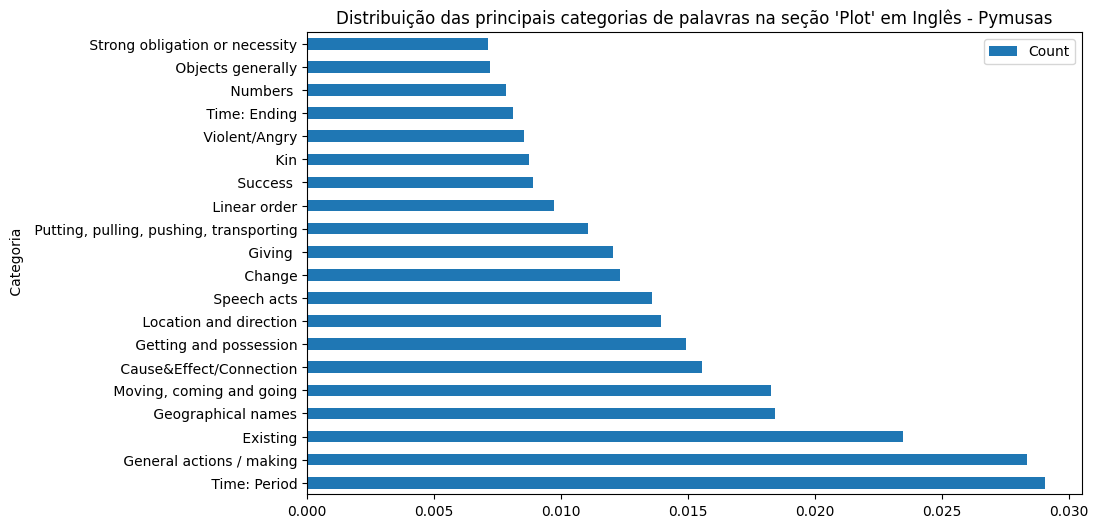

In [57]:
df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras na seção 'Plot' em Inglês - Pymusas")
plt.yticks(fontsize=10)
plt.show()

In [87]:
path = './data/plots_es'
text = ""
list_files = os.listdir(path)
print(list_files)

['Los emigrantes.txt', 'La canción de Bernadette.txt', 'El halcón maltés (película de 1941).txt', 'Atonement (película).txt', 'Picnic (película).txt', 'Barry Lyndon.txt', 'La forma del agua.txt', 'Espejismo de amor.txt', 'Fuego en la nieve (película).txt', 'Hugo (película).txt', 'Three Billboards Outside Ebbing, Missouri.txt', 'Cat on a Hot Tin Roof (película).txt', 'Gladiator.txt', 'The Reader.txt', 'El cielo y tú.txt', 'América, América (película).txt', 'Fugitivos (película de 1958).txt', 'Jerry Maguire.txt', 'Sense and Sensibility (película).txt', 'El orgullo de los Yanquis.txt', 'El séptimo cielo (película).txt', 'El Señor de los Anillos: el retorno del Rey.txt', 'Grandes esperanzas (película de 1946).txt', 'War Horse.txt', 'The Towering Inferno.txt', 'In Old Chicago.txt', 'Mr. Smith Goes to Washington.txt', 'Midnight Cowboy.txt', 'La fuerza del cariño.txt', 'Zorba, el griego (película).txt', 'Pasaje a la India.txt', 'The Magnificent Ambersons.txt', 'Minari.txt', 'Dunkerque (pelícu

In [46]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_es(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [89]:
list_files = ["E.T., el extraterrestre.txt", "Star Wars: Episodio IV - Una nueva esperanza.txt", "Black Panther (película).txt"]
results = []
for file in list_files:
    name = file.split(".txt")
    if name[0] in plots["TITLE_ES"].values:
        article = open(path + "/" + file, 'r')
        content = article.read()
        result = process_text(content)
        results.append(result)
results

[[{'Text': 'El', 'Lemma': 'el', 'POS': 'DET', 'USAS Tags': ['Z5']},
  {'Text': 'filme', 'Lemma': 'filme', 'POS': 'NOUN', 'USAS Tags': ['Z99']},
  {'Text': 'comienza',
   'Lemma': 'comenzar',
   'POS': 'VERB',
   'USAS Tags': ['M1']},
  {'Text': 'en', 'Lemma': 'en', 'POS': 'ADP', 'USAS Tags': ['Z5', 'N3']},
  {'Text': 'Crescent',
   'Lemma': 'Crescent',
   'POS': 'PROPN',
   'USAS Tags': ['Z99']},
  {'Text': 'City', 'Lemma': 'City', 'POS': 'PROPN', 'USAS Tags': ['Z99']},
  {'Text': ',', 'Lemma': ',', 'POS': 'PUNCT', 'USAS Tags': ['PUNCT']},
  {'Text': 'California',
   'Lemma': 'California',
   'POS': 'PROPN',
   'USAS Tags': ['Z2', 'M7']},
  {'Text': ',', 'Lemma': ',', 'POS': 'PUNCT', 'USAS Tags': ['PUNCT']},
  {'Text': 'con', 'Lemma': 'con', 'POS': 'ADP', 'USAS Tags': ['Z5', 'A4.1']},
  {'Text': 'un', 'Lemma': 'uno', 'POS': 'DET', 'USAS Tags': ['Z5', 'N1']},
  {'Text': 'grupo',
   'Lemma': 'grupo',
   'POS': 'NOUN',
   'USAS Tags': ['S5+', 'A4.1', 'B3', 'S5+c', 'A4.1c', 'G1', 'S2', 'I1

In [90]:
df = pd.read_csv("pymusas_dict.csv", sep=";")
df["Count"] = [0 for i in range(len(df))]
df.set_index('Tag', inplace=True)
df

,Categoria,Count
Tag,,
A1,General And Abstract Terms,0
A1.1.1,General actions / making,0
A1.1.1-,Inaction,0
A1.1.2,Damaging and destroying,0
A1.1.2-,Fixing and mending,0
...,...,...
Z7,If,0
Z7-,Unconditional,0
Z8,Pronouns,0


In [91]:
for result in results:
    for sub_result in result:
        for tag in sub_result['USAS Tags']:
            if tag in df.index:
                df.at[tag, 'Count'] += 1

df["Count"] = df["Count"] / df["Count"].sum()
df = df.reset_index()
for index, row in df.iterrows():
    if row["Count"] == 0:
        df = df.drop(index)
df = df.sort_values(by="Count", ascending=False)
df

,Tag,Categoria,Count
446,Z5,Grammatical bin,0.246187
452,Z99,Unmatched,0.130719
450,Z8,Pronouns,0.041152
213,N3,Measurement,0.017913
211,N1,Numbers,0.017187
...,...,...,...
393,X2.5-,Not understanding,0.000242
101,B2+,Healthy,0.000242
401,X3.2,Sensory: Sound,0.000242
189,K3,Recorded sound,0.000242


In [92]:
df_aux = df.drop([446, 452, 450])
df_aux

,Tag,Categoria,Count
213,N3,Measurement,0.017913
211,N1,Numbers,0.017187
24,A1.8+,Inclusion,0.016703
202,M1,"Moving, coming and going",0.015735
235,N4,Linear order,0.015251
...,...,...,...
393,X2.5-,Not understanding,0.000242
101,B2+,Healthy,0.000242
401,X3.2,Sensory: Sound,0.000242
189,K3,Recorded sound,0.000242


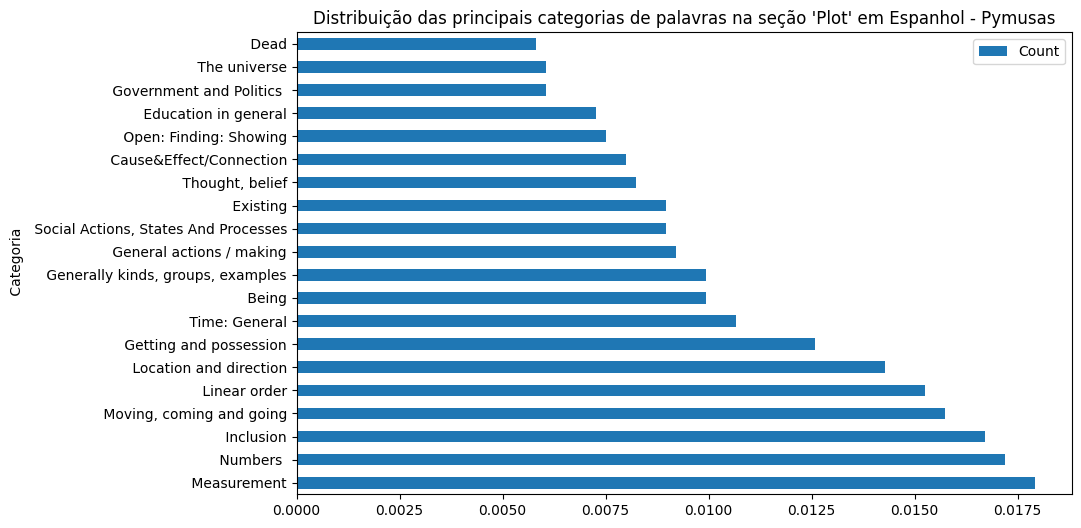

In [93]:
df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras na seção 'Plot' em Espanhol - Pymusas")
plt.yticks(fontsize=10)
plt.show()

Executando para filmes individuais

In [35]:
def process_text(text):
    output_doc = nlp_es(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

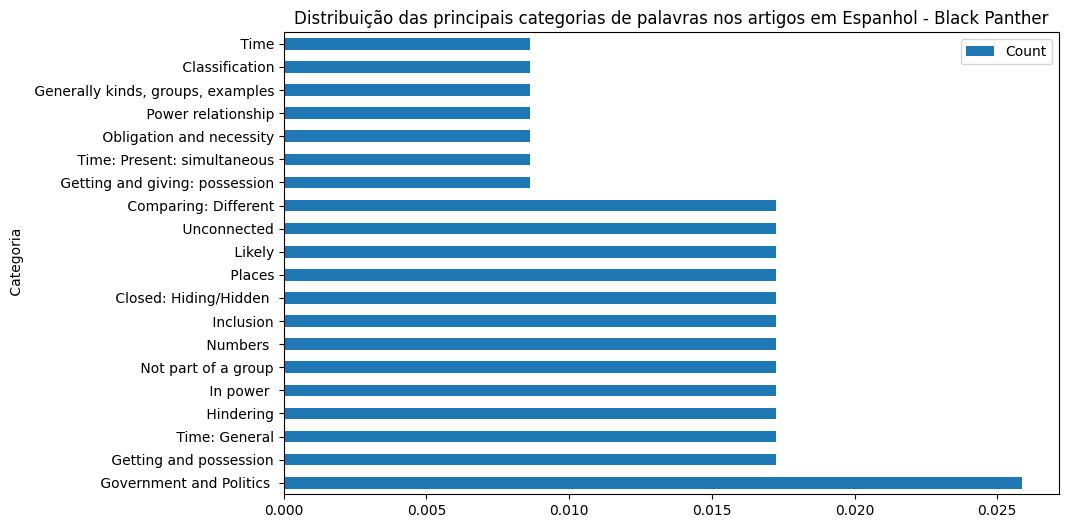

In [86]:
#list_files = ["La La Land (película).txt", "El mago de Oz.txt", "The Sound of Music.txt"]
list_files = ["E.T., el extraterrestre.txt", "Star Wars: Episodio IV - Una nueva esperanza.txt", "Black Panther (película).txt"]
#list_files = ["Everything Everywhere All at Once.txt", "Star Wars: Episódio IV – Uma Nova Esperança.txt", "Black Panther (filme).txt"]
article = open("./data/plots_es/Black Panther (película).txt", 'r')
content = article.read()
result = process_text(content)

df_test = pd.read_csv("pymusas_dict.csv", sep=";")
df_test["Count"] = [0 for i in range(len(df_test))]
df_test.set_index('Tag', inplace=True)

for sub_result in result:
    for tag in sub_result['USAS Tags']:
        if tag == 'A5.4+':
            break
        if tag in df_test.index:
            df_test.at[tag, 'Count'] += 1

df_test["Count"] = df_test["Count"] / df_test["Count"].sum()

df_test.to_csv("teste_df.csv", sep=';', index=True)

df_test = df_test.reset_index()
for index, row in df_test.iterrows():
    if row["Count"] == 0:
        df_test = df_test.drop(index)
df_test = df_test.sort_values(by="Count", ascending=False)


df_aux = df_test.drop([446, 452, 450])

df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Espanhol - Black Panther")
plt.yticks(fontsize=10)
plt.show()

In [9]:
# Função para processar cada texto
def process_text(text):
    output_doc = nlp_en(str(text))
    result = []
    for token in output_doc:
        result.append({
        'Text': token.text,
        'Lemma': token.lemma_,
        'POS': token.pos_,
        'USAS Tags': token._.pymusas_tags
        })
    return result

In [5]:
film_names_en = []
film_names_es = []
film_names_pt = []

list_direc_en = os.listdir("./data/plots_en/")
list_direc_es = os.listdir("./data/plots_es/")
list_direc_pt = os.listdir("./data/plots_pt/")

for movie in sorted(list_direc_en):
    movie = movie.split(".txt")[0]
    film_names_en.append(movie)

for movie in sorted(list_direc_es):
    movie = movie.split(".txt")[0]
    film_names_es.append(movie)

for movie in sorted(list_direc_pt):
    movie = movie.split(".txt")[0]
    film_names_pt.append(movie)


In [33]:
movies_classification = {
    "Movie that makes social critics": [
        "12 Angry Men (1957 film)", 
        "A Clockwork Orange (film)", 
        "American Beauty (1999 film)", 
        "Get Out", 
        "Crash (2004 film)", 
        "Good Night, and Good Luck", 
        "Network (1976 film)", 
        "The Great Dictator", 
        "The Social Network",
        "Room (2015 film)", 
        "The Revenant (2015 film)",
        "Green Book (film)", 
        "Everything Everywhere All at Once",
        "Don't Look Up",
        "Joker (2019 film)"
    ],
    "Fantasy and Imaginary worlds": [
        "Avatar (2009 film)", 
        "Avatar: The Way of Water", 
        "District 9", 
        "E.T. the Extra-Terrestrial", 
        "Inception", 
        "The Shape of Water", 
        "The Wizard of Oz",
        "Star Wars (film)",
        "The Lord of the Rings: The Fellowship of the Ring", 
        "The Lord of the Rings: The Return of the King", 
        "The Lord of the Rings: The Two Towers"
    ],
    "Movies about historical events or people or War and Fights": [
        "12 Years a Slave (film)", 
        "1917 (2019 film)", 
        "A Man for All Seasons (1966 film)", 
        "A Farewell to Arms (1932 film)", 
        "All the President's Men (film)", 
        "Argo (2012 film)", 
        "Apollo 13 (film)", 
        "Gandhi (film)", 
        "Schindler's List", 
        "Lincoln (film)", 
        "The King's Speech", 
        "The Pianist (2002 film)", 
        "The Last Emperor",
        "Ben-Hur (1959 film)",
        "The Queen (2006 film)", 
        "Cleopatra (1963 film)",
        "Life Is Beautiful",
        "Saving Private Ryan",
        "Ford v Ferrari", 
        "Elvis (2022 film)",
        "The Imitation Game",
        "Inglourious Basterds", 
        "Gladiator (2000 film)",
        "Dunkirk (2017 film)", 
        "Darkest Hour (film)",
        "Bohemian Rhapsody (film)",
        "All Quiet on the Western Front (1930 film)",
        "All Quiet on the Western Front (2022 film)"
    ],
    "Musicals or Comedies or Love": [
        "42nd Street (film)", 
        "An American in Paris (film)", 
        "Anchors Aweigh (film)", 
        "Annie Hall", 
        "Chicago (2002 film)", 
        "Funny Girl (film)", 
        "La La Land", 
        "Mary Poppins (film)", 
        "Moulin Rouge!", 
        "Seven Brides for Seven Brothers", 
        "The Sound of Music (film)", 
        "Top Hat",
        "Beauty and the Beast (1991 film)",
        "Roman Holiday", 
        "Titanic (1997 film)",
        "A Star Is Born (1937 film)", 
        "A Star Is Born (2018 film)"
    ],
    "Movies about life's occurrences": [
        "127 Hours", 
        "A Beautiful Mind (film)", 
        "Boyhood (2014 film)", 
        "Driving Miss Daisy", 
        "Fargo (1996 film)", 
        "Good Will Hunting", 
        "Juno (film)", 
        "Marriage Story", 
        "Ordinary People", 
        "Terms of Endearment",
        "Little Women (1933 film)", 
        "Little Women (2019 film)",
        "Forrest Gump",
        "Once Upon a Time in Hollywood",
        "Midnight in Paris",
        "Gone with the Wind (film)"
    ],
    "Adventure": [
        "Around the World in 80 Days (1956 film)", 
        "Braveheart", 
        "Indiana Jones: Raiders of the Lost Ark", 
        "Life of Pi (film)", 
        "Mad Max: Fury Road", 
        "The Adventures of Robin Hood",
        "Top Gun: Maverick",
        "The Martian (film)"
    ],
    "Power relations": [
        "A Few Good Men", 
        "All the King's Men (1949 film)", 
        "Amadeus (film)", 
        "Dangerous Liaisons", 
        "Doctor Zhivago (film)", 
        "Frost_Nixon (film)", 
        "Henry V (1944 film)", 
        "JFK (film)", 
        "The Godfather", 
        "The Godfather Part II", 
        "The Godfather Part III", 
        "The Wolf of Wall Street (2013 film)"
    ],
    "Others": [
        "49th Parallel (film)", 
        "7th Heaven (1927 film)", 
        "A Room with a View (1985 film)",  
        "A Streetcar Named Desire (1951 film)", 
        "Alice Adams (1935 film)", 
        "All This, and Heaven Too", 
        "Atlantic City (1980 film)", 
        "Babe (film)", 
        "Barry Lyndon",  
        "Birdman (film)", 
        "Black Swan (film)", 
        "Bonnie and Clyde (film)", 
        "Broadcast News (film)", 
        "Cabaret (1972 film)", 
        "Capote (film)", 
        "Casablanca (film)", 
        "Cat on a Hot Tin Roof (1958 film)", 
        "Cavalcade (1933 film)", 
        "Chariots of Fire", 
        "Chinatown (1974 film)", 
        "Citizen Kane", 
        "Coal Miner's Daughter (film)", 
        "Coming Home (1978 film)", 
        "Cries and Whispers", 
        "Crossfire (film)", 
        "Crouching Tiger, Hidden Dragon", 
        "Dances with Wolves", 
        "Dark Victory", 
        "Dead End (1937 film)", 
        "Decision Before Dawn", 
        "Deliverance", 
        "Disraeli (1929 film)", 
        "Doctor Dolittle (1967 film)", 
        "Dodsworth (film)", 
        "Dog Day Afternoon", 
        "Double Indemnity", 
        "Dr. Strangelove", 
        "East Lynne (1931 film)", 
        "Elizabeth (film)", 
        "Erin Brockovich (film)", 
        "Extremely Loud & Incredibly Close (film)", 
        "Fanny (1961 film)", 
        "Fatal Attraction", 
        "Father of the Bride (1950 film)", 
        "Fiddler on the Roof (film)", 
        "Field of Dreams", 
        "Finding Neverland (film)", 
        "Five Easy Pieces", 
        "Five Star Final", 
        "Flirtation Walk", 
        "For Whom the Bell Tolls (film)", 
        "Foreign Correspondent (film)", 
        "Four Weddings and a Funeral", 
        "Friendly Persuasion (1956 film)", 
        "From Here to Eternity", 
        "Funny Girl (film)", 
        "Gangs of New York", 
        "Gaslight (1944 film)", 
        "Gentleman's Agreement", 
        "Giant (1956 film)", 
        "Gigi (1958 film)",  
        "Going My Way", 
        "Gosford Park", 
        "Grand Hotel (1932 film)", 
        "Gravity (2013 film)", 
        "Guess Who's Coming to Dinner", 
        "Hacksaw Ridge", 
        "Hamlet (1948 film)", 
        "Heaven Can Wait (1943 film)", 
        "Heaven Can Wait (1978 film)", 
        "Here Comes Mr. Jordan", 
        "Hold Back the Dawn", 
        "How Green Was My Valley (film)", 
        "How the West Was Won (film)", 
        "Howards End (film)", 
        "Hugo (film)", 
        "I Am a Fugitive from a Chain Gang", 
        "Imitation of Life (1934 film)", 
        "In Old Chicago", 
        "In Which We Serve", 
        "In the Bedroom", 
        "In the Heat of the Night (film)", 
        "In the Name of the Father (film)", 
        "It Happened One Night", 
        "It's a Wonderful Life", 
        "Ivanhoe (1952 film)", 
        "Jaws (film)", 
        "Jerry Maguire", 
        "Jezebel (1938 film)", 
        "Johnny Belinda (1948 film)", 
        "Judgment at Nuremberg", 
        "Julia (1977 film)", 
        "King Solomon's Mines (1950 film)", 
        "Kings Row", 
        "Kiss of the Spider Woman (film)", 
        "Kitty Foyle (film)", 
        "Kramer vs. Kramer", 
        "L.A. Confidential (film)", 
        "La Grande Illusion", 
        "Lady for a Day", 
        "Lawrence of Arabia (film)", 
        "Lenny (film)", 
        "Les Misérables (2012 film)", 
        "Libeled Lady",  
        "Lilies of the Field (1963 film)", 
        "Little Miss Sunshine", 
        "Lost Horizon (1937 film)", 
        "Lost in Translation (film)", 
        "Love Affair (1939 film)", 
        "Love Story (1970 film)", 
        "M*A*S*H (film)", 
        "Manchester by the Sea (film)", 
        "Mank", 
        "Marty (film)", 
        "Master and Commander: The Far Side of the World", 
        "Michael Clayton", 
        "Midnight Cowboy", 
        "Mildred Pierce (film)", 
        "Min and Bill", 
        "Mister Roberts (1955 film)", 
        "Moonlight (2016 film)", 
        "Mrs. Miniver", 
        "Mutiny on the Bounty (1935 film)", 
        "My Fair Lady (film)", 
        "My Left Foot", 
        "Mystic River (film)", 
        "Nashville (film)", 
        "No Country for Old Men (film)", 
        "No Way Out (1950 film)", 
        "Norma Rae", 
        "Ninotchka", 
        "Nomadland (film)", 
        "Notorious (1946 film)", 
        "Now, Voyager", 
        "Of Mice and Men (1939 film)", 
        "On Golden Pond (1981 film)", 
        "On the Waterfront", 
        "One Flew Over the Cuckoo's Nest (film)", 
        "One Foot in Heaven", 
        "One Hour with You",
        "One Night of Love",
        "Out of Africa (film)", 
        "Patton (film)",
        "Pulp Fiction", 
        "Raging Bull", 
        "Rain Man", 
        "Rebecca (1940 film)", 
        "Reds (film)", 
        "Sense and Sensibility (film)", 
        "Sergeant York", 
        "Shakespeare in Love",
        "Silver Linings Playbook",
        "Smilin' Through (1932 film)",
        "Sounder (film)", 
        "Stage Door (film)", 
        "Suspicion (1941 film)", 
        "The Awful Truth", 
        "The Barretts of Wimpole Street (1934 film)", 
        "The Big Chill",
        "The Blind Side (film)", 
        "The Broadway Melody", 
        "The Cardinal (1963 film)", 
        "The Cider House Rules (film)", 
        "The Color Purple (film)", 
        "The Country Girl (1954 film)", 
        "The Crying Game", 
        "The Curious Case of Benjamin Button (film)", 
        "The Deer Hunter", 
        "The Defiant Ones", 
        "The Departed", 
        "The Descendants", 
        "The Diary of Anne Frank (1959 film)", 
        "The Emigrants (film)", 
        "The End of the Affair (1999 film)", 
        "The English Patient (film)", 
        "The Favourite", 
        "The Fighter", 
        "The French Connection (film)", 
        "The Fugitive (1993 film)", 
        "The Full Monty", 
        "The Goodbye Girl", 
        "The Grand Budapest Hotel", 
        "The Grapes of Wrath (film)", 
        "The Green Mile (film)", 
        "The Guns of Navarone (film)", 
        "The Heiress (film)", 
        "The Hours (film)", 
        "The Hurt Locker", 
        "The Hustler (film)",  
        "The Insider", 
        "The Irishman", 
        "The Killing Fields (film)", 
        "The Kids Are All Right (film)", 
        "The Last Picture Show", 
        "The Life of Emile Zola", 
        "The Lion in Winter (1968 film)", 
        "The Little Foxes (film)", 
        "The Lost Weekend", 
        "The Magnificent Ambersons (film)", 
        "The Maltese Falcon (1941 film)", 
        "The Matrix", 
        "The Mission (1986 film)", 
        "The More the Merrier", 
        "The Nun's Story", 
        "The Phantom of the Opera (2004 film)", 
        "The Pride of the Yankees", 
        "The Quiet Man", 
        "The Reader (2008 film)",  
        "The Right Stuff (film)", 
        "The Road to Perdition", 
        "The Rose Tattoo (film)", 
        "The Seventh Heaven", 
        "The Seventh Seal", 
        "The Sixth Sense", 
        "The Social Network", 
        "The Talk of the Town (1942 film)", 
        "The Ten Commandments (1956 film)", 
        "The Thin Man (film)", 
        "The Thin Red Line (1998 film)", 
        "The Third Man", 
        "The Towering Inferno", 
        "The Tree of Life (film)", 
        "The Turning Point (1977 film)", 
        "The Verdict", 
        "The Way We Were", 
        "The White Parade", 
        "The Whistleblower", 
        "The Wind and the Lion", 
        "The Yearling (1946 film)", 
        "There Will Be Blood", 
        "Three Coins in the Fountain (film)", 
        "Three Smart Girls", 
        "Three Times Three", 
        "To Kill a Mockingbird (film)", 
        "Tootsie", 
        "Touch of Evil", 
        "Tower Heist", 
        "Traffic (2000 film)", 
        "Triumph of the Will", 
        "Twelve O'Clock High", 
        "Two for the Seesaw", 
        "Unforgiven",
        "Victor/Victoria (1982 film)", 
        "Waking Ned",
        "West Side Story (2021 film)", 
        "West Side Story (film)", 
        "Whiplash (2014 film)", 
        "Who's Afraid of Virginia Woolf? (film)", 
        "Winter's Bone", 
        "Witness (1985 film)",
        "Wuthering Heights (1939 film)", 
    ]
}

s = 0
for key, value in movies_classification.items():
    for movie in value:
        if movie not in film_names_en:
            value.remove(movie)

    s += len(value)
s

321

In [64]:
plots = pd.read_csv("./data/oscar_full_plot.csv", sep=';')
plots.set_index("TITULO", inplace = True)

for movie in movies_classification["Movie that makes social critics"]:
    movie_name = plots.at[movie, "TITLE_ES"]
    print(movie_name)
    if movie_name in film_names_en:
        article = open("./data/plots_es/" + movie_name + ".txt", 'r')
        content = article.read()
        result = process_text(content)

        df_test = pd.read_csv("pymusas_dict.csv", sep=";")
        df_test["Count"] = [0 for i in range(len(df_test))]
        df_test.set_index('Tag', inplace=True)

        for sub_result in result:
            for tag in sub_result['USAS Tags']:
                if tag in df_test.index:
                    df_test.at[tag, 'Count'] += 1

df_test["Count"] = df_test["Count"] / df_test["Count"].sum()

df_test.to_csv("teste_df.csv", sep=';', index=True)

df_test = df_test.reset_index()
for index, row in df_test.iterrows():
    if row["Count"] == 0:
        df_test = df_test.drop(index)
df_test = df_test.sort_values(by="Count", ascending=False)

df_aux = df_test.drop([36, 55, 211, 446, 452, 450])
#print(df_aux.head(20))

df_plot = df_aux.iloc[:20]
df_plot.plot(x=" Categoria", y=["Count"], kind='barh', figsize=(10,6))
plt.title("Distribuição das principais categorias de palavras nos artigos em Espanhol - Musicais, Comédias ou Romance")
plt.yticks(fontsize=10)
plt.show()

12 Angry Men (película de 1957)


KeyError: 'A Clockwork Orange (film)'

In [83]:
index_df = sorted(plots.index)

list_direc = os.listdir("./data/plots_en/")
list_movies = sorted(list_direc)

print(index_df)
dict_ = {}
for i in range(len(index_df)):
    if index_df[i].upper() == list_movies[i].split(".txt")[0].upper():
        dict_[list_movies[i].split(".txt")[0]] = index_df[i]
    else:
        if index_df[i].upper() in list_movies[i].split(".txt")[0].upper() or list_movies[i].split(".txt")[0].upper() in index_df[i].upper():
            dict_[list_movies[i].split(".txt")[0]] = index_df[i]
        else:
            print(list_movies[i].split(".txt")[0], index_df[i])
print(dict_)

['12 Angry Men (1957 film)', '12 Years a Slave (film)', '127 Hours', '1917 (2019 film)', '42nd Street (film)', '49th Parallel (film)', '7th Heaven (1927 film)', 'A BEAUTIFUL MIND (2001 film)', 'A CLOCKWORK ORANGE (1971 film)', 'A Farewell to Arms (1932 film)', 'A Few Good Men', 'A Letter to Three Wives', 'A Man for All Seasons (1966 film)', 'A PASSAGE TO INDIA (1984 film)', 'A PLACE IN THE SUN (film)', 'A Room with a View (1985 film)', 'A SERIOUS MAN (2009 film)', "A SOLDIER'S STORY (1984 film)", 'A Star Is Born (1937 film)', 'A Star Is Born (2018 film)', 'A Streetcar Named Desire (1951 film)', 'AIRPORT (1970 film)', 'ALL THAT JAZZ (1979 film)', "ALL THE PRESIDENT'S MEN (1976 film)", 'AMADEUS (1984 film)', 'AN EDUCATION (2009 film)', 'ANATOMY OF A MURDER (1959 film)', 'ANCHORS AWEIGH (film)', 'ANNIE HALL (1977 film)', 'APOCALYPSE NOW (1979 film)', 'ARGO (2012 film)', 'AROUND THE WORLD IN 80 DAYS (film)', 'AS GOOD AS IT GETS (1997 film)', 'AVATAR (2009 film)', 'AWAKENINGS (1990 film)', 